```
function ClickConnect(){
console.log("Working");
document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)
```

In [0]:
#from google.colab import auth
#auth.authenticate_user()

In [0]:
!gsutil cp gs://deepfake_mljc_bucket/Audio/audio_data_unique.h5 /content/audio_data_unique.h5

Copying gs://deepfake_mljc_bucket/Audio/audio_data_unique.h5...
- [1 files][  2.4 GiB/  2.4 GiB]   21.2 MiB/s                                   
Operation completed over 1 objects/2.4 GiB.                                      


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from tqdm import tqdm, tqdm_notebook
import pickle
import h5py

rnd = 42

In [0]:
import time
start = time.time()

with h5py.File('/content/audio_data_unique.h5', 'r') as hf:
    X = (hf['X'][:])
    Y = (hf['Y'][:])

print(time.time()-start)

25.646870136260986


In [0]:
#u = np.unique(X,return_index=True,axis=0)
#X = u[0]
#Y = Y[u[1]]

In [0]:
#del u

In [0]:
Y.shape

(8457, 1)

In [0]:
X.shape

(8457, 128, 1024)

(array([3364.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5093.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

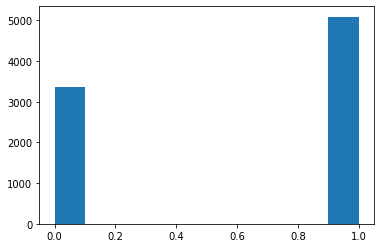

In [0]:
plt.hist(Y)

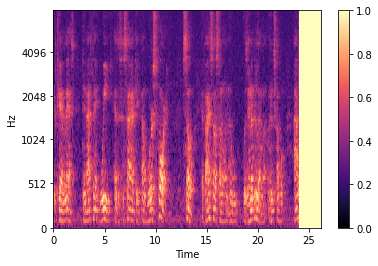

In [0]:
librosa.display.specshow(X[1676,:,:], x_axis='time',y_axis='mel', sr=20000,fmax=8000)
plt.colorbar();

# TCN pytorch implementation

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import sklearn

distributions = {
    'num_channels' : (2**np.arange(3,10).reshape(7,1)).tolist(),
    'kernel_size' : np.arange(2,20).astype(int),
    'dropout' : uniform(loc=0.1, scale=0.8)
    }

In [0]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


'''
original implementation: https://github.com/locuslab/TCN
'''

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.1)
        self.conv2.weight.data.normal_(0, 0.1)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.1)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class DeepFakeAudio(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(DeepFakeAudio, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.sigmoid(self.linear(y1[:, :, -1]))
        return o

In [0]:
# ======================
#    CV Model Creation
# ======================
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

DEVICE = "cuda"

class CV_model(BaseEstimator, ClassifierMixin):
  def __init__(self, 
               num_channels=[64],
               kernel_size=3,
               dropout=0.1,
               lr=1e-3,
               early_stopping=3,
               max_epochs=50):

    self.num_channels = num_channels
    self.kernel_size = kernel_size
    self.dropout = dropout
    self.lr = lr
    self.early_stopping = early_stopping
    self.max_epochs = max_epochs

  def weights_init(self, m):
    classname = m.__class__.__name__
    if classname.find('Conv1d') != -1:
      m.weight.data.normal_(0, 0.1)
      m.weight.data.normal_(0, 0.1)

    if classname.find('Linear') != -1:
      # get the number of the inputs
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

  def fit(self, X, Y):
    
    self.model = DeepFakeAudio(input_size=128, output_size=1, num_channels=self.num_channels, kernel_size=self.kernel_size, dropout=self.dropout)
    self.model.to(DEVICE)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    loss = nn.BCELoss()
    self.model.apply(self.weights_init)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=rnd)

    train_data = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(Y_train).float()
        )
    
    val_data = TensorDataset(
        torch.from_numpy(X_val).float(),
        torch.from_numpy(Y_val).float()
        )

    train_data_loader = DataLoader(train_data, batch_size=512, shuffle=True)
    val_data_loader = DataLoader(val_data, batch_size=512, shuffle=False)
    self.losses = np.zeros([self.max_epochs,2])
    self.accs = np.zeros([self.max_epochs,2])
    max_acc = 0
    patient = 0
    
    for ep in range(self.max_epochs):
      l = []
      a = []
      for Xb, Yb in train_data_loader:
        self.model.train()
        y_pred = self.model(Xb.to(DEVICE))
        loss_batch = loss(y_pred, Yb.reshape(-1,1).float().to(DEVICE))
        a.append(torch.sum(torch.round(y_pred)==Yb.reshape(-1,1).to(DEVICE)).item()/len(y_pred))
        l.append(loss_batch.item())
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
      
      self.losses[ep,0] = np.mean(l)
      self.accs[ep,0] = np.mean(a)

      with torch.no_grad():
        self.model.eval()
        
        l = []
        a = []
        for Xb, Yb in val_data_loader:
          y_pred = self.model(Xb.to(DEVICE))
          l.append(loss(y_pred, Yb.reshape(-1,1).float().to(DEVICE)).item())
          a.append(torch.sum(torch.round(y_pred)==Yb.reshape(-1,1).to(DEVICE)).item()/len(y_pred))

        self.losses[ep,1] = np.mean(l)
        self.accs[ep,1] = np.mean(a)

      if self.accs[ep,1] > max_acc:
        torch.save(self.model.state_dict(), '/content/checkpoint.pt')
        max_acc = self.accs[ep,1]
        patient = 0
      else:
        patient += 1
      
      if patient >= self.early_stopping:
        self.model.load_state_dict(torch.load('/content/checkpoint.pt'))
        break

    return self
  
  def predict(self, X):
    
    test_data = TensorDataset(
        torch.from_numpy(X).float())

    test_data_loader = DataLoader(
        test_data, batch_size=512, shuffle=False)

    self.model.eval()
    test_preds = []
    with torch.no_grad():
      for Xb in test_data_loader:
        test_preds.append(self.model(Xb[0].to(DEVICE)).to('cpu').detach().numpy())

    return np.vstack(test_preds)

  def score(self, X, Y):

    pred = self.predict(X)

    score = roc_auc_score(Y,pred)
    #score = accuracy_score(Y,np.round(pred))

    return score

In [0]:
#m = CV_model()

In [0]:
#m.fit(X[:,:,:512],Y)

In [0]:
#F,ax=plt.subplots(1,2,figsize=(13,5))
#ax[0].plot(m.losses[:,0],label='train')
#ax[0].plot(m.losses[:,1],label='validation')
#ax[0].legend()

#ax[1].plot(m.accs[:,0],label='train')
#ax[1].plot(m.accs[:,1],label='validation')
#ax[1].legend()
#print(f"val accuracy: {m.accs[-1,1]}")
#print(f"train accuracy: {m.accs[-1,0]}")

In [0]:
#m.score(X[:,:,:512],Y)

In [0]:
folds = 5
param_comb = 20

skf = sklearn.model_selection.KFold(n_splits=folds, shuffle=True)

random_search = RandomizedSearchCV(CV_model(), 
                                   param_distributions=distributions,
                                   n_iter=param_comb, 
                                   n_jobs=1, 
                                   cv=skf.split(X[:,:,:512],Y),
                                   random_state=0, 
                                   verbose=1)   
 
# Here we go 
random_search.fit(X[:,:,:512],Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:
import gc
gc.collect()
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

In [0]:
torch.cuda.memory_allocated(device=None)*1e-9

In [0]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best score:')
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)

In [0]:
results.sort_values('rank_test_score')

In [0]:
results.to_csv('/content/drive/My Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/Audio/CV/One_layer_TCN/cv_results_0.csv')